# 0. Import Dependencies

In [1]:
import random
import pandas as pd
from transformers import BertTokenizer, BertModel, Trainer, TrainingArguments
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader 
from sklearn.metrics import mean_squared_error # MSE
import os
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. Data Loader

In [2]:
# 연주 feature 및 점수 파일이 있는 폴더 경로
midi_feature_base_path = "midi_data/bach"

# 연주자 폴더 목록
performers = ["hyunsung", "jeo", "jihyun", "jinhee", "jungwook"]

# 청크 길이 정의 (100개 요소 = 10초)
segment_length = 100

all_segments = []
all_scores = []

# dynamic 전처리용
replace_dict = {np.nan: 0, '': 0, 'ppp': 1, 'pp': 2, 'p': 3, 'mp': 4, 'mf': 5, 'f': 6, 'ff': 7, 'fff': 8}

# pedal 전처리 함수
def filter_pedal(pedal_value):
    if isinstance(pedal_value, str):
        if pedal_value.startswith('['):
            pedal_list = eval(pedal_value)
            return 1 if any(v >= 64 for v in pedal_list) else 0
        else:
            pedal_value = int(pedal_value)
            return 1 if pedal_value >= 64 else 0
    elif isinstance(pedal_value, list):
        return 1 if any(v >= 64 for v in pedal_value) else 0
    elif isinstance(pedal_value, int):
        return 1 if pedal_value >= 64 else 0
    else:
        return 0

for performer in performers:
    feature_folder = os.path.join(midi_feature_base_path, performer)
    print(f"Checking files in performer folder: {feature_folder}")
    
    for file_name in os.listdir(feature_folder):
        if "target" not in file_name and file_name.endswith(".csv") and not file_name.endswith("_score.csv"):
            # Feature와 Score 파일 경로
            feature_file_path = os.path.join(feature_folder, file_name)
            base_name = file_name.replace(".csv", "")
            score_file_name = f"{base_name}_score.csv"
            score_file_path = os.path.join(feature_folder, score_file_name)

            if os.path.exists(score_file_path):
                print(f"\nProcessing {file_name} and {score_file_name}")
                
                features = pd.read_csv(feature_file_path)
                scores = pd.read_csv(score_file_path).iloc[:, 1:].values.tolist()

                # `note` 값 처리
                def process_note(x):
                    if pd.isna(x) or x == "[]":
                        return "note_0"
                    elif isinstance(x, str) and x.startswith("["):
                        return "note_" + ",".join(
                            str(int(v)) for v in eval(x) if pd.notna(v)
                        )
                    else:
                        return f"note_{int(x)}"
                
                features["note"] = features["note"].apply(process_note)

                # `dynamic` 값 처리
                features["dynamic"] = features["dynamic"].replace(replace_dict)

                # `pedal` 값 처리
                features["pedal"] = features["pedal"].apply(filter_pedal)

                # MIDI 데이터를 10초씩 나누기 위한 문자열 생성
                midi_features = features.apply(
                    lambda row: (
                        f"time_{row['sec']:.1f}: {row['note']}_dynamic_{row['dynamic']}_pedal_{row['pedal']}"
                    ),
                    axis=1
                ).tolist()

                # 10초씩 나누기
                midi_segments = [
                    "; ".join(midi_features[i:i + segment_length]) 
                    for i in range(0, len(midi_features), segment_length)
                ]

                # 세그먼트와 점수 길이 맞추기
                if len(midi_segments) > len(scores):
                    midi_segments = midi_segments[:len(scores)]
                elif len(midi_segments) < len(scores):
                    padding = "; ".join([
                        f"time_{i * 0.1:.1f}: note_0_dynamic_0_pedal_0"
                        for i in range(segment_length)
                    ])
                    while len(midi_segments) < len(scores):
                        midi_segments.append(padding)

                # 전체 데이터에 추가
                all_segments.extend(midi_segments)
                all_scores.extend(scores)

                print(f"\n--- File: {file_name} ---")
                print(f"Number of segments: {len(midi_segments)}")
                print(f"Number of scores: {len(scores)}")
                print("\nSegments:")
                for idx, segment in enumerate(midi_segments[:3]):  # 상위 3개만 출력
                    print(f"  Segment {idx + 1}: {segment[:100]}...")
                print("\nScores:")
                print(scores[:3])  # 상위 3개 점수 출력(디버깅용)
            else:
                print(f"Score file not found for: {file_name}")

print(f"\nTotal Segments: {len(all_segments)}")
print(f"Total Scores: {len(all_scores)}")

Checking files in performer folder: midi_data/bach/hyunsung

Processing bach_dynamic_bad2.csv and bach_dynamic_bad2_score.csv

--- File: bach_dynamic_bad2.csv ---
Number of segments: 11
Number of scores: 11

Segments:
  Segment 1: time_0.0: note_60_dynamic_5_pedal_0; time_0.1: note_0_dynamic_0_pedal_0; time_0.2: note_64_dynamic_4...
  Segment 2: time_10.0: note_0_dynamic_0_pedal_0; time_10.1: note_72_dynamic_3_pedal_0; time_10.2: note_76_dynami...
  Segment 3: time_20.0: note_74_dynamic_3_pedal_0; time_20.1: note_0_dynamic_0_pedal_0; time_20.2: note_79_dynami...

Scores:
[[98.0, 55.0, 98.16, 0.0, 88.0], [100.0, 29.0, 100.0, 0.0, 90.4], [99.0, 47.0, 100.0, 0.0, 96.4]]

Processing bach_note_perfect1.csv and bach_note_perfect1_score.csv

--- File: bach_note_perfect1.csv ---
Number of segments: 11
Number of scores: 11

Segments:
  Segment 1: time_0.0: note_64_dynamic_3_pedal_0; time_0.1: note_67_dynamic_3_pedal_0; time_0.2: note_0_dynamic_0...
  Segment 2: time_10.0: note_0_dynamic_0_pedal

/tmp/ipykernel_1547318/337189812.py:64: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features["dynamic"] = features["dynamic"].replace(replace_dict)
/tmp/ipykernel_1547318/337189812.py:64: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features["dynamic"] = features["dynamic"].replace(replace_dict)
/tmp/ipykernel_1547318/337189812.py:64: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to


--- File: bach_dynamic_perfect2.csv ---
Number of segments: 11
Number of scores: 11

Segments:
  Segment 1: time_0.0: note_60_dynamic_3_pedal_0; time_0.1: note_64_dynamic_3_pedal_0; time_0.2: note_0_dynamic_0...
  Segment 2: time_10.0: note_0_dynamic_0_pedal_0; time_10.1: note_72_dynamic_5_pedal_0; time_10.2: note_0_dynamic...
  Segment 3: time_20.0: note_74_dynamic_4_pedal_1; time_20.1: note_0_dynamic_0_pedal_1; time_20.2: note_79_dynami...

Scores:
[[96.5, 91.0, 99.07, 84.0, 89.2], [97.0, 87.0, 99.07, 0.0, 88.0], [99.0, 84.0, 100.0, 82.0, 95.2]]

Processing bach_note_bad1.csv and bach_note_bad1_score.csv

--- File: bach_note_bad1.csv ---
Number of segments: 11
Number of scores: 11

Segments:
  Segment 1: time_0.0: note_62,64_dynamic_3_pedal_1; time_0.1: note_67_dynamic_3_pedal_1; time_0.2: note_0_dynami...
  Segment 2: time_10.0: note_0_dynamic_0_pedal_1; time_10.1: note_72_dynamic_4_pedal_0; time_10.2: note_0_dynamic...
  Segment 3: time_20.0: note_75_dynamic_6_pedal_0; time_20.1: 

/tmp/ipykernel_1547318/337189812.py:64: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features["dynamic"] = features["dynamic"].replace(replace_dict)
/tmp/ipykernel_1547318/337189812.py:64: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features["dynamic"] = features["dynamic"].replace(replace_dict)
/tmp/ipykernel_1547318/337189812.py:64: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to


--- File: bach_pedal_bad.csv ---
Number of segments: 11
Number of scores: 11

Segments:
  Segment 1: time_0.0: note_60_dynamic_4_pedal_0; time_0.1: note_0_dynamic_0_pedal_0; time_0.2: note_64_dynamic_3...
  Segment 2: time_10.0: note_72_dynamic_5_pedal_0; time_10.1: note_0_dynamic_0_pedal_0; time_10.2: note_76_dynami...
  Segment 3: time_20.0: note_74_dynamic_4_pedal_0; time_20.1: note_79_dynamic_4_pedal_0; time_20.2: note_0_dynami...

Scores:
[[99.0, 76.0, 100.0, 100.0, 90.4], [98.0, 79.0, 99.07, 96.0, 90.4], [98.0, 83.0, 99.07, 100.0, 88.0]]

Processing bach_dynamic_perfect2.csv and bach_dynamic_perfect2_score.csv

--- File: bach_dynamic_perfect2.csv ---
Number of segments: 11
Number of scores: 11

Segments:
  Segment 1: time_0.0: note_60_dynamic_3_pedal_0; time_0.1: note_64_dynamic_3_pedal_0; time_0.2: note_0_dynamic_0...
  Segment 2: time_10.0: note_0_dynamic_0_pedal_0; time_10.1: note_72_dynamic_5_pedal_0; time_10.2: note_0_dynamic...
  Segment 3: time_20.0: note_74_dynamic_6_ped

/tmp/ipykernel_1547318/337189812.py:64: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features["dynamic"] = features["dynamic"].replace(replace_dict)
/tmp/ipykernel_1547318/337189812.py:64: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features["dynamic"] = features["dynamic"].replace(replace_dict)
/tmp/ipykernel_1547318/337189812.py:64: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to


--- File: bach_pedal_bad.csv ---
Number of segments: 11
Number of scores: 11

Segments:
  Segment 1: time_0.0: note_64_dynamic_3_pedal_1; time_0.1: note_0_dynamic_0_pedal_0; time_0.2: note_67_dynamic_4...
  Segment 2: time_9.8: note_67_dynamic_3_pedal_0; time_9.9: note_0_dynamic_0_pedal_0; time_10.0: note_72_dynamic_...
  Segment 3: time_19.2: note_74_dynamic_3_pedal_0; time_19.2: note_79_dynamic_4_pedal_0; time_19.3: note_0_dynami...

Scores:
[[93.0, 79.0, 97.13, 100.0, 79.6], [87.0, 83.0, 92.21, 100.0, 76.0], [86.0, 84.0, 85.77, 100.0, 76.0]]

Processing bach_dynamic_perfect2.csv and bach_dynamic_perfect2_score.csv

--- File: bach_dynamic_perfect2.csv ---
Number of segments: 11
Number of scores: 11

Segments:
  Segment 1: time_0.0: note_64_dynamic_3_pedal_1; time_0.1: note_0_dynamic_0_pedal_0; time_0.2: note_0_dynamic_0_...
  Segment 2: time_9.7: note_0_dynamic_0_pedal_0; time_9.8: note_67_dynamic_4_pedal_1; time_9.9: note_0_dynamic_0_...
  Segment 3: time_19.3: note_62_dynamic_5_pe

/tmp/ipykernel_1547318/337189812.py:64: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features["dynamic"] = features["dynamic"].replace(replace_dict)
/tmp/ipykernel_1547318/337189812.py:64: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features["dynamic"] = features["dynamic"].replace(replace_dict)
/tmp/ipykernel_1547318/337189812.py:64: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to


--- File: bach_pedal_bad.csv ---
Number of segments: 11
Number of scores: 11

Segments:
  Segment 1: time_0.0: note_60_dynamic_3_pedal_0; time_0.1: note_64_dynamic_3_pedal_0; time_0.2: note_0_dynamic_0...
  Segment 2: time_9.5: note_0_dynamic_0_pedal_1; time_9.6: note_64_dynamic_3_pedal_0; time_9.8: note_67_dynamic_3...
  Segment 3: time_19.5: note_67_dynamic_3_pedal_0; time_19.2: note_74,79_dynamic_4_pedal_1; time_19.4: note_67_dy...

Scores:
[[91.5, 88.0, 93.21, 100.0, 90.4], [89.0, 86.0, 88.67, 100.0, 86.8], [84.5, 96.0, 85.77, 100.0, 83.2]]

Processing bach_dynamic_perfect2.csv and bach_dynamic_perfect2_score.csv

--- File: bach_dynamic_perfect2.csv ---
Number of segments: 11
Number of scores: 11

Segments:
  Segment 1: time_0.0: note_60,64_dynamic_3_pedal_1; time_0.1: note_0_dynamic_0_pedal_0; time_0.2: note_0_dynamic...
  Segment 2: time_9.6: note_64_dynamic_4_pedal_0; time_9.7: note_0_dynamic_0_pedal_0; time_9.8: note_67_dynamic_4...
  Segment 3: time_19.5: note_0_dynamic_0_ped

/tmp/ipykernel_1547318/337189812.py:64: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features["dynamic"] = features["dynamic"].replace(replace_dict)
/tmp/ipykernel_1547318/337189812.py:64: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features["dynamic"] = features["dynamic"].replace(replace_dict)
/tmp/ipykernel_1547318/337189812.py:64: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to


--- File: bach_pedal_bad.csv ---
Number of segments: 11
Number of scores: 11

Segments:
  Segment 1: time_0.0: note_60_dynamic_3_pedal_0; time_0.1: note_0_dynamic_0_pedal_0; time_0.2: note_64_dynamic_3...
  Segment 2: time_10.0: note_0_dynamic_0_pedal_0; time_10.1: note_72_dynamic_4_pedal_0; time_10.2: note_0_dynamic...
  Segment 3: time_20.0: note_74_dynamic_4_pedal_0; time_20.1: note_0_dynamic_0_pedal_0; time_20.2: note_79_dynami...

Scores:
[[98.5, 73.0, 99.07, 100.0, 90.4], [100.0, 80.0, 100.0, 100.0, 80.8], [98.0, 80.0, 100.0, 100.0, 83.2]]

Processing bach_dynamic_perfect2.csv and bach_dynamic_perfect2_score.csv

--- File: bach_dynamic_perfect2.csv ---
Number of segments: 11
Number of scores: 11

Segments:
  Segment 1: time_0.0: note_0_dynamic_0_pedal_0; time_0.0: note_0_dynamic_0_pedal_1; time_0.1: note_60_dynamic_2_...
  Segment 2: time_3.2: note_0_dynamic_0_pedal_0; time_3.2: note_0_dynamic_0_pedal_0; time_3.2: note_69_dynamic_3_...
  Segment 3: time_7.1: note_0_dynamic_0_ped

/tmp/ipykernel_1547318/337189812.py:64: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features["dynamic"] = features["dynamic"].replace(replace_dict)
/tmp/ipykernel_1547318/337189812.py:64: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features["dynamic"] = features["dynamic"].replace(replace_dict)
/tmp/ipykernel_1547318/337189812.py:64: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to

In [3]:
midi_feature_base_path = "midi_data/bach"

performers = ["hyunsung", "jeo", "jihyun", "jinhee", "jungwook"]

segment_length = 100

replace_dict = {np.nan: 0, '': 0, 'ppp': 1, 'pp': 2, 'p': 3, 'mp': 4, 'mf': 5, 'f': 6, 'ff': 7, 'fff': 8}

def filter_pedal(pedal_value):
    if isinstance(pedal_value, str):
        if pedal_value.startswith('['):
            pedal_list = eval(pedal_value)
            return 1 if any(v >= 64 for v in pedal_list) else 0
        else:
            pedal_value = int(pedal_value)
            return 1 if pedal_value >= 64 else 0
    elif isinstance(pedal_value, list):
        return 1 if any(v >= 64 for v in pedal_value) else 0
    elif isinstance(pedal_value, int):
        return 1 if pedal_value >= 64 else 0
    else:
        return 0

# 정규화 함수
def normalize(scores, min_vals, max_vals):
    return [(np.array(score) - min_vals) / (max_vals - min_vals) for score in scores]

all_segments = []
all_scores = []

for performer in performers:
    feature_folder = os.path.join(midi_feature_base_path, performer)
    print(f"Checking files in performer folder: {feature_folder}")
    
    for file_name in os.listdir(feature_folder):
        if "target" not in file_name and file_name.endswith(".csv") and not file_name.endswith("_score.csv"):
            feature_file_path = os.path.join(feature_folder, file_name)
            base_name = file_name.replace(".csv", "")
            score_file_name = f"{base_name}_score.csv"
            score_file_path = os.path.join(feature_folder, score_file_name)

            if os.path.exists(score_file_path):
                print(f"\nProcessing {file_name} and {score_file_name}")
                
                features = pd.read_csv(feature_file_path)
                scores = pd.read_csv(score_file_path).iloc[:, 1:].values.tolist()

                # `note` 값 처리
                def process_note(x):
                    if pd.isna(x) or x == "[]":
                        return "note_0"
                    elif isinstance(x, str) and x.startswith("["):
                        return "note_" + ",".join(
                            str(int(v)) for v in eval(x) if pd.notna(v)
                        )
                    else:
                        return f"note_{int(x)}"
                
                features["note"] = features["note"].apply(process_note)

                # `dynamic` 값 처리
                features["dynamic"] = features["dynamic"].replace(replace_dict)

                # `pedal` 값 처리
                features["pedal"] = features["pedal"].apply(filter_pedal)

                # MIDI 데이터를 10초씩 나누기 위한 문자열 생성
                midi_features = features.apply(
                    lambda row: (
                        f"time_{row['sec']:.1f}: {row['note']}_dynamic_{row['dynamic']}_pedal_{row['pedal']}"
                    ),
                    axis=1
                ).tolist()

                midi_segments = [
                    "; ".join(midi_features[i:i + segment_length]) 
                    for i in range(0, len(midi_features), segment_length)
                ]

                # 세그먼트와 점수 길이 맞추기
                if len(midi_segments) > len(scores):
                    midi_segments = midi_segments[:len(scores)]
                elif len(midi_segments) < len(scores):
                    padding = "; ".join([
                        f"time_{i * 0.1:.1f}: note_0_dynamic_0_pedal_0"
                        for i in range(segment_length)
                    ])
                    while len(midi_segments) < len(scores):
                        midi_segments.append(padding)

                # 전체 데이터에 추가
                all_segments.extend(midi_segments)
                all_scores.extend(scores)

print(f"\nTotal Segments: {len(all_segments)}")
print(f"Total Scores: {len(all_scores)}")

# 점수 데이터프레임 생성
scores_df = pd.DataFrame(all_scores, columns=["note_score", "dynamic_score", "articulation_score", "accent_score", "pedal_score"])

# 정규화 최소/최대값 계산
min_vals = scores_df.min().values
max_vals = scores_df.max().values

print("Minimum Values:", min_vals)
print("Maximum Values:", max_vals)

# 점수 정규화
all_scores_normalized = normalize(all_scores, min_vals, max_vals)

# 데이터 분리
train_segments, test_segments, train_scores, test_scores = train_test_split(
    all_segments, all_scores_normalized, test_size=0.2, random_state=42
)

print(f"\nTotal Data: {len(all_segments)} segments")
print(f"Training Data: {len(train_segments)} segments")
print(f"Testing Data: {len(test_segments)} segments")

Checking files in performer folder: midi_data/bach/hyunsung

Processing bach_dynamic_bad2.csv and bach_dynamic_bad2_score.csv

Processing bach_note_perfect1.csv and bach_note_perfect1_score.csv

Processing bach_dynamic_bad1.csv and bach_dynamic_bad1_score.csv

Processing bach_note_perfect2.csv and bach_note_perfect2_score.csv

Processing bach_pedal_perfect.csv and bach_pedal_perfect_score.csv


/tmp/ipykernel_1547318/1063371156.py:62: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features["dynamic"] = features["dynamic"].replace(replace_dict)
/tmp/ipykernel_1547318/1063371156.py:62: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features["dynamic"] = features["dynamic"].replace(replace_dict)
/tmp/ipykernel_1547318/1063371156.py:62: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in


Processing bach_pedal_bad.csv and bach_pedal_bad_score.csv

Processing bach_dynamic_perfect2.csv and bach_dynamic_perfect2_score.csv


/tmp/ipykernel_1547318/1063371156.py:62: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features["dynamic"] = features["dynamic"].replace(replace_dict)
/tmp/ipykernel_1547318/1063371156.py:62: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features["dynamic"] = features["dynamic"].replace(replace_dict)



Processing bach_note_bad1.csv and bach_note_bad1_score.csv

Processing bach_dynamic_perfect1.csv and bach_dynamic_perfect1_score.csv

Processing bach_note_bad2.csv and bach_note_bad2_score.csv
Checking files in performer folder: midi_data/bach/jeo

Processing bach_dynamic_bad2.csv and bach_dynamic_bad2_score.csv

Processing bach_note_perfect1.csv and bach_note_perfect1_score.csv

Processing bach_dynamic_bad1.csv and bach_dynamic_bad1_score.csv


/tmp/ipykernel_1547318/1063371156.py:62: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features["dynamic"] = features["dynamic"].replace(replace_dict)
/tmp/ipykernel_1547318/1063371156.py:62: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features["dynamic"] = features["dynamic"].replace(replace_dict)
/tmp/ipykernel_1547318/1063371156.py:62: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in


Processing bach_note_perfect2.csv and bach_note_perfect2_score.csv

Processing bach_pedal_perfect.csv and bach_pedal_perfect_score.csv

Processing bach_pedal_bad.csv and bach_pedal_bad_score.csv


/tmp/ipykernel_1547318/1063371156.py:62: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features["dynamic"] = features["dynamic"].replace(replace_dict)
/tmp/ipykernel_1547318/1063371156.py:62: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features["dynamic"] = features["dynamic"].replace(replace_dict)
/tmp/ipykernel_1547318/1063371156.py:62: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in


Processing bach_dynamic_perfect2.csv and bach_dynamic_perfect2_score.csv

Processing bach_note_bad1.csv and bach_note_bad1_score.csv

Processing bach_dynamic_perfect1.csv and bach_dynamic_perfect1_score.csv

Processing bach_note_bad2.csv and bach_note_bad2_score.csv
Checking files in performer folder: midi_data/bach/jihyun

Processing bach_dynamic_bad2.csv and bach_dynamic_bad2_score.csv

Processing bach_note_perfect1.csv and bach_note_perfect1_score.csv

Processing bach_dynamic_bad1.csv and bach_dynamic_bad1_score.csv


/tmp/ipykernel_1547318/1063371156.py:62: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features["dynamic"] = features["dynamic"].replace(replace_dict)
/tmp/ipykernel_1547318/1063371156.py:62: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features["dynamic"] = features["dynamic"].replace(replace_dict)
/tmp/ipykernel_1547318/1063371156.py:62: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in


Processing bach_note_perfect2.csv and bach_note_perfect2_score.csv

Processing bach_pedal_perfect.csv and bach_pedal_perfect_score.csv


/tmp/ipykernel_1547318/1063371156.py:62: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features["dynamic"] = features["dynamic"].replace(replace_dict)
/tmp/ipykernel_1547318/1063371156.py:62: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features["dynamic"] = features["dynamic"].replace(replace_dict)
/tmp/ipykernel_1547318/1063371156.py:62: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in


Processing bach_pedal_bad.csv and bach_pedal_bad_score.csv

Processing bach_dynamic_perfect2.csv and bach_dynamic_perfect2_score.csv

Processing bach_note_bad1.csv and bach_note_bad1_score.csv

Processing bach_dynamic_perfect1.csv and bach_dynamic_perfect1_score.csv

Processing bach_note_bad2.csv and bach_note_bad2_score.csv
Checking files in performer folder: midi_data/bach/jinhee

Processing bach_dynamic_bad2.csv and bach_dynamic_bad2_score.csv

Processing bach_note_perfect1.csv and bach_note_perfect1_score.csv

Processing bach_dynamic_bad1.csv and bach_dynamic_bad1_score.csv


/tmp/ipykernel_1547318/1063371156.py:62: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features["dynamic"] = features["dynamic"].replace(replace_dict)
/tmp/ipykernel_1547318/1063371156.py:62: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features["dynamic"] = features["dynamic"].replace(replace_dict)
/tmp/ipykernel_1547318/1063371156.py:62: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in


Processing bach_note_perfect2.csv and bach_note_perfect2_score.csv

Processing bach_pedal_perfect.csv and bach_pedal_perfect_score.csv


/tmp/ipykernel_1547318/1063371156.py:62: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features["dynamic"] = features["dynamic"].replace(replace_dict)
/tmp/ipykernel_1547318/1063371156.py:62: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features["dynamic"] = features["dynamic"].replace(replace_dict)
/tmp/ipykernel_1547318/1063371156.py:62: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in


Processing bach_pedal_bad.csv and bach_pedal_bad_score.csv

Processing bach_dynamic_perfect2.csv and bach_dynamic_perfect2_score.csv

Processing bach_note_bad1.csv and bach_note_bad1_score.csv

Processing bach_dynamic_perfect1.csv and bach_dynamic_perfect1_score.csv

Processing bach_note_bad2.csv and bach_note_bad2_score.csv
Checking files in performer folder: midi_data/bach/jungwook

Processing bach_dynamic_bad2.csv and bach_dynamic_bad2_score.csv

Processing bach_note_perfect1.csv and bach_note_perfect1_score.csv

Processing bach_dynamic_bad1.csv and bach_dynamic_bad1_score.csv

Processing bach_note_perfect2.csv and bach_note_perfect2_score.csv

Processing bach_pedal_perfect.csv and bach_pedal_perfect_score.csv


/tmp/ipykernel_1547318/1063371156.py:62: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features["dynamic"] = features["dynamic"].replace(replace_dict)
/tmp/ipykernel_1547318/1063371156.py:62: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features["dynamic"] = features["dynamic"].replace(replace_dict)
/tmp/ipykernel_1547318/1063371156.py:62: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in


Processing bach_pedal_bad.csv and bach_pedal_bad_score.csv

Processing bach_dynamic_perfect2.csv and bach_dynamic_perfect2_score.csv

Processing bach_note_bad1.csv and bach_note_bad1_score.csv

Processing bach_dynamic_perfect1.csv and bach_dynamic_perfect1_score.csv

Processing bach_note_bad2.csv and bach_note_bad2_score.csv

Total Segments: 550
Total Scores: 550
Minimum Values: [61.5  0.   0.   0.  76. ]
Maximum Values: [100. 100. 100. 100. 100.]

Total Data: 550 segments
Training Data: 440 segments
Testing Data: 110 segments


/tmp/ipykernel_1547318/1063371156.py:62: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features["dynamic"] = features["dynamic"].replace(replace_dict)
/tmp/ipykernel_1547318/1063371156.py:62: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features["dynamic"] = features["dynamic"].replace(replace_dict)
/tmp/ipykernel_1547318/1063371156.py:62: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in

In [4]:
class MidiDataset(Dataset):
    def __init__(self, segments, scores, tokenizer, max_length=512):
        self.segments = segments
        self.scores = scores
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        segment = self.segments[idx]
        score = self.scores[idx]
        
        encoding = self.tokenizer(
            segment,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(score, dtype=torch.float)
        }
    
class BertForMultipleRegression(nn.Module):
    def __init__(self):
        super(BertForMultipleRegression, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.regressor = nn.Linear(self.bert.config.hidden_size, 5)  # 5 outputs for 5 scores

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        predictions = self.regressor(pooled_output)

        if labels is not None:
            loss_fn = nn.MSELoss()
            loss = loss_fn(predictions, labels)
            return loss, predictions
        return predictions

model = BertForMultipleRegression()

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

train_dataset = MidiDataset(train_segments, train_scores, tokenizer)
test_dataset = MidiDataset(test_segments, test_scores, tokenizer)

model = BertForMultipleRegression()

# MSE 평가 함수
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.reshape(-1, 5)  # 5개의 점수를 예측하므로 reshape 필요
    labels = labels.reshape(-1, 5)            # labels도 같은 형식으로 reshape
    
    # 다중 점수의 평균 MSE 계산
    mse = mean_squared_error(labels, predictions, multioutput='uniform_average')
    return {"mse": mse}

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=15,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=3e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="mse",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

/home/viplab/anaconda3/envs/deepfake/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


[2025-01-21 13:26:22,808] [INFO] [real_accelerator.py:222:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/viplab/anaconda3/envs/deepfake/compiler_compat/ld: cannot find -laio: 그런 파일이나 디렉터리가 없습니다
collect2: error: ld returned 1 exit status
/home/viplab/anaconda3/envs/deepfake/compiler_compat/ld: warning: libstdc++.so.6, needed by /usr/local/cuda-12.1/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/viplab/anaconda3/envs/deepfake/compiler_compat/ld: warning: libm.so.6, needed by /usr/local/cuda-12.1/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/home/viplab/anaconda3/envs/deepfake/compiler_compat/ld: /usr/local/cuda-12.1/lib64/libcufile.so: undefined reference to `std::runtime_error::~runtime_error()@GLIBCXX_3.4'
/home/viplab/anaconda3/envs/deepfake/compiler_compat/ld: /usr/local/cuda-12.1/lib64/libcufile.so: undefined reference to `__gxx_personality_v0@CXXABI_1.3'
/home/viplab/anaconda3/envs/deepfake/compiler_compat/ld: /usr/local/cuda-12.1/lib64/libcufile.so: undefined reference to `std::ostream::tellp()@GLIBCXX_3.4'
/home/viplab/anaconda3/envs/d

In [5]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

batch = next(iter(train_loader))

print("Batch Input IDs:", batch["input_ids"].shape)
print(batch["input_ids"])

print("Batch Attention Mask:", batch["attention_mask"].shape)
print(batch["attention_mask"])

print("Batch Labels:", batch["labels"].shape)
print(batch["labels"])

Batch Input IDs: torch.Size([8, 512])
tensor([[ 101, 2051, 1035,  ..., 1022, 1024,  102],
        [ 101, 2051, 1035,  ..., 1022, 1024,  102],
        [ 101, 2051, 1035,  ..., 1022, 1024,  102],
        ...,
        [ 101, 2051, 1035,  ..., 1022, 1024,  102],
        [ 101, 2051, 1035,  ..., 1015, 1024,  102],
        [ 101, 2051, 1035,  ..., 1022, 1024,  102]])
Batch Attention Mask: torch.Size([8, 512])
tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])
Batch Labels: torch.Size([8, 5])
tensor([[0.9351, 0.6500, 1.0000, 0.0000, 0.6500],
        [0.2696, 0.6700, 0.7627, 0.0000, 0.9500],
        [0.7662, 0.9000, 0.9446, 0.7600, 0.6500],
        [0.2392, 0.9200, 0.7223, 0.9091, 0.8000],
        [0.9740, 0.7700, 1.0000, 1.0000, 0.6500],
        [0.1429, 0.7400, 0.8915, 0.5217, 0.8000],
        [0.6623, 0.7100, 0.9379, 0.0000, 0

In [6]:
train_scores[0]

array([0.8961039, 0.79     , 1.       , 0.92     , 0.6      ])

Epoch,Training Loss,Validation Loss,Mse
1,0.122300,0.064529,0.064529
2,0.078000,0.062573,0.062573
3,0.078000,0.062780,0.062780
4,0.068700,0.056439,0.056439
5,0.062400,0.055285,0.055285
6,0.051100,0.048156,0.048156
7,0.048700,0.040930,0.040930
8,0.044700,0.044474,0.044474
9,0.037700,0.040096,0.040096
10,0.037400,0.044843,0.044843



Evaluation Results: {'eval_loss': 0.06452858448028564, 'eval_mse': 0.06452859938144684, 'eval_runtime': 2.6992, 'eval_samples_per_second': 40.753, 'eval_steps_per_second': 5.187, 'epoch': 15.0}


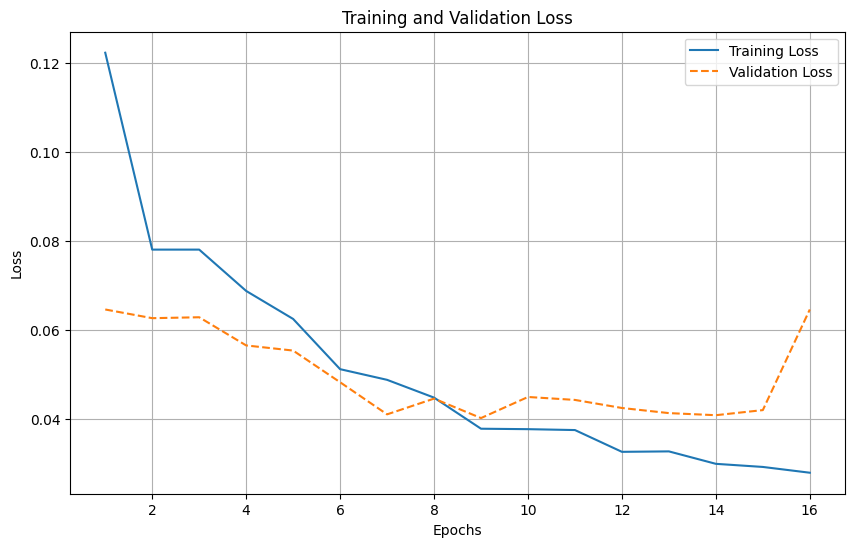

In [7]:
train_result = trainer.train()

eval_results = trainer.evaluate()
print("\nEvaluation Results:", eval_results)

def extract_loss_from_logs(logs): # for visualization
    train_losses = []
    eval_losses = []
    for log in logs:
        if "loss" in log:  # 학습 손실
            train_losses.append(log["loss"])
        if "eval_loss" in log:  # 평가 손실
            eval_losses.append(log["eval_loss"])
    return train_losses, eval_losses

train_losses, eval_losses = extract_loss_from_logs(trainer.state.log_history)

def plot_loss(training_logs, evaluation_logs):
    epochs_train = range(1, len(training_logs) + 1)
    epochs_eval = range(1, len(evaluation_logs) + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_train, training_logs, label="Training Loss")
    plt.plot(epochs_eval, evaluation_logs, label="Validation Loss", linestyle="--")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(training_logs=train_losses, evaluation_logs=eval_losses)

### 정리
- Note Score: 약 4.74
- Dynamic Score: 약 13.94
- Articulation Score: 약 7.36
- Accent Score: 약 35.81
- Pedal Score: 약 2.86

In [10]:
from safetensors.torch import load_file

# 모델 로드
model_path = "./results/checkpoint-825"
model = BertForMultipleRegression()

model.load_state_dict(load_file(os.path.join(model_path, "model.safetensors")))
model.eval()

# Tokenizer 로드
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# 데이터 전처리 함수
def preprocess_midi_file(file_path, segment_length=100):
    features = pd.read_csv(file_path)

    # dynamic 전처리용 매핑
    replace_dict = {np.nan: 0, '': 0, 'ppp': 1, 'pp': 2, 'p': 3, 'mp': 4, 'mf': 5, 'f': 6, 'ff': 7, 'fff': 8}

    # `note` 전처리
    def process_note(x):
        if pd.isna(x) or x == "[]":
            return "note_0"
        elif isinstance(x, str) and x.startswith("["):
            return "note_" + ",".join(str(int(v)) for v in eval(x) if pd.notna(v))
        else:
            return f"note_{int(x)}"

    features["note"] = features["note"].apply(process_note)

    # `dynamic` 전처리
    features["dynamic"] = features["dynamic"].replace(replace_dict)

    # `pedal` 전처리
    def filter_pedal(pedal_value):
        if isinstance(pedal_value, str):
            if pedal_value.startswith('['):
                pedal_list = eval(pedal_value)
                return 1 if any(v >= 64 for v in pedal_list) else 0
            else:
                pedal_value = int(pedal_value)
                return 1 if pedal_value >= 64 else 0
        elif isinstance(pedal_value, list):
            return 1 if any(v >= 64 for v in pedal_value) else 0
        elif isinstance(pedal_value, int):
            return 1 if pedal_value >= 64 else 0
        else:
            return 0

    features["pedal"] = features["pedal"].apply(filter_pedal)

    # MIDI 데이터를 10초씩 나누기 위한 문자열 생성
    midi_features = features.apply(
        lambda row: (
            f"time_{row['sec']:.1f}: {row['note']}_dynamic_{row['dynamic']}_pedal_{row['pedal']}"
        ),
        axis=1
    ).tolist()

    # 10초씩 나누기
    midi_segments = [
        "; ".join(midi_features[i:i + segment_length])
        for i in range(0, len(midi_features), segment_length)
    ]

    return midi_segments

# 역정규화 함수
def denormalize(predictions, min_vals, max_vals):
    predictions = torch.tensor(predictions)
    min_vals = torch.tensor(min_vals)
    max_vals = torch.tensor(max_vals)
    return (predictions * (max_vals - min_vals) + min_vals).tolist()

# MIDI 파일 경로
midi_file_path = "midi_data/bach/jeo/bach_note_perfect1.csv"
midi_segments = preprocess_midi_file(midi_file_path)

# 데이터 준비 함수
def prepare_data_for_prediction(segments, tokenizer, max_length=512):
    inputs = tokenizer(
        segments,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_tensors="pt"
    )
    return inputs

# 데이터 준비
inputs = prepare_data_for_prediction(midi_segments, tokenizer)
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

# 예측 수행
with torch.no_grad():
    predictions = model(input_ids, attention_mask)

# 디버깅 출력
print("Raw Predictions Shape:", predictions.shape)
print("Raw Predictions (First 5):", predictions[:5])

# 정규화 최소/최대값 (학습 시 사용한 값으로 교체)
train_min = [0, 0, 0, 0, 0]  # 실제 학습 데이터 최소값
train_max = [100, 100, 100, 100, 100]  # 실제 학습 데이터 최대값

# 역정규화된 예측 결과 출력
denormalized_predictions = denormalize(predictions.numpy(), train_min, train_max)

print("Predicted Scores:")
for i, pred in enumerate(denormalized_predictions):
    print(f"Segment {i + 1}: {pred}")

/tmp/ipykernel_1547318/2286704625.py:32: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  features["dynamic"] = features["dynamic"].replace(replace_dict)


Raw Predictions Shape: torch.Size([11, 5])
Raw Predictions (First 5): tensor([[0.9259, 0.8793, 0.9981, 0.7182, 0.6198],
        [0.9201, 0.6624, 1.0094, 0.0152, 0.5915],
        [0.9638, 0.8943, 0.9987, 0.9603, 0.6287],
        [0.9728, 0.7682, 0.9542, 0.2916, 0.5985],
        [1.0264, 0.8190, 1.0069, 0.3864, 0.6445]])
Predicted Scores:
Segment 1: [92.5888442993164, 87.93012237548828, 99.80562591552734, 71.82158660888672, 61.98021697998047]
Segment 2: [92.01400756835938, 66.23592376708984, 100.93716430664062, 1.5190532207489014, 59.149776458740234]
Segment 3: [96.38447570800781, 89.4330062866211, 99.86951446533203, 96.02934265136719, 62.8674430847168]
Segment 4: [97.27874755859375, 76.82344818115234, 95.42405700683594, 29.156652450561523, 59.85066223144531]
Segment 5: [102.639404296875, 81.89624786376953, 100.69190216064453, 38.63884353637695, 64.44967651367188]
Segment 6: [99.7353286743164, 82.09025573730469, 99.3475112915039, 92.7196273803711, 67.49838256835938]
Segment 7: [94.057342

In [11]:
df_score = pd.read_csv('midi_data/bach/jeo/bach_note_perfect1_score.csv')
df_score

,chunk,note_score,dynamic_score,articulation_score,accent_score,pedal_score
0,1,97.5,81.0,99.12,44.00,89.2
1,2,97.0,84.0,100.00,0.00,95.2
2,3,99.0,79.0,99.09,88.00,94.0
3,4,99.0,74.0,100.00,0.00,92.8
4,5,100.0,83.0,100.00,12.00,94.0
5,6,99.0,66.0,100.00,48.00,95.2
6,7,99.0,79.0,100.00,60.00,92.8
7,8,100.0,70.0,100.00,0.00,91.6
8,9,100.0,85.0,100.00,2.00,94.0
9,10,98.5,70.0,100.00,88.00,90.4


## Score Distribution Visualization

In [ ]:
plt.figure(figsize=(12, 6))
plt.hist(
    [score for scores in train_scores for score in scores], 
    bins=20, alpha=0.5, label='Train Scores', color='blue'
)
plt.hist(
    [score for scores in test_scores for score in scores], 
    bins=20, alpha=0.5, label='Test Scores', color='orange'
)

plt.title('Score Distribution Visualization', fontsize=16)
plt.xlabel('Score (Normalized)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()